In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

<Axes: xlabel='Date'>

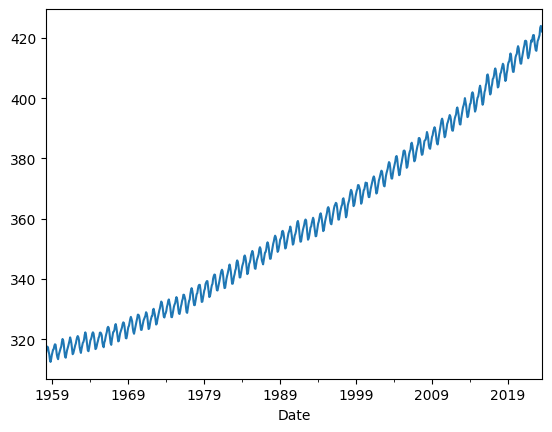

In [2]:
df = pd.read_csv("../data/co2_mm_mlo.csv")
df["Date"] = df["year"].astype(str) + "-" + df["month"].astype(str)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["average"].plot()

In [3]:
y_tr = df["average"].values[-72:-24]
T_tr = y_tr.size
y_te = df["average"].values[-24:]
T_te = y_te.size
S = 12

data = dict(
    y_tr=y_tr,
    T_tr=T_tr,
    y_te=y_te,
    T_te=T_te,
    S=S
)

In [8]:
model = CmdStanModel(stan_file="../models_ts/co2_structual-time-series_v2.stan")

22:28:51 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series_v2.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series_v2
22:29:21 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series_v2


In [9]:
fit = model.sample(
    data=data,
    iter_warmup=1500, iter_sampling=1500, chains=3, show_console=False,
    # parallel_chains=6,
    adapt_delta=0.999,
    max_treedepth=20,
)

22:29:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

22:32:13 - cmdstanpy - INFO - CmdStan done processing.
22:32:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.5%)
	Chain 2 had 13 divergent transitions (0.9%)
	Chain 3 had 24 divergent transitions (1.6%)
	Use function "diagnose()" to see further information.


In [10]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmpn9qih4bd/co2_structual-time-series_v2wwp_twhz/co2_structual-time-series_v2-20230826222921_1.csv, /tmp/tmpn9qih4bd/co2_structual-time-series_v2wwp_twhz/co2_structual-time-series_v2-20230826222921_2.csv, /tmp/tmpn9qih4bd/co2_structual-time-series_v2wwp_twhz/co2_structual-time-series_v2-20230826222921_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
45 of 4500 (1.00%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.06, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample si

In [11]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,271.241000,7.373030,42.227700,217.992000,262.922000,362.252000,32.8021,0.212591,1.08401
s_z,0.037226,0.001600,0.017995,0.015317,0.034046,0.070213,126.5440,0.820133,1.02725
s_v,0.206773,0.007309,0.051939,0.112483,0.209555,0.289165,50.4929,0.327245,1.04580
s_s,0.077854,0.010340,0.056752,0.005291,0.068100,0.187511,30.1226,0.195225,1.09184
mu[1],406.979000,0.006243,0.172293,406.696000,406.979000,407.260000,761.7280,4.936770,1.00710
...,...,...,...,...,...,...,...,...,...
gamma_hat[68],1.509600,0.005379,0.245536,1.136230,1.492250,1.916600,2083.7600,13.504900,1.00532
gamma_hat[69],2.719270,0.014551,0.258543,2.363250,2.683430,3.204370,315.7020,2.046060,1.01288
gamma_hat[70],3.089700,0.012951,0.249975,2.624880,3.123590,3.436390,372.5680,2.414620,1.01289
gamma_hat[71],2.497800,0.003619,0.238800,2.108140,2.500500,2.887910,4352.9400,28.211500,0.99980


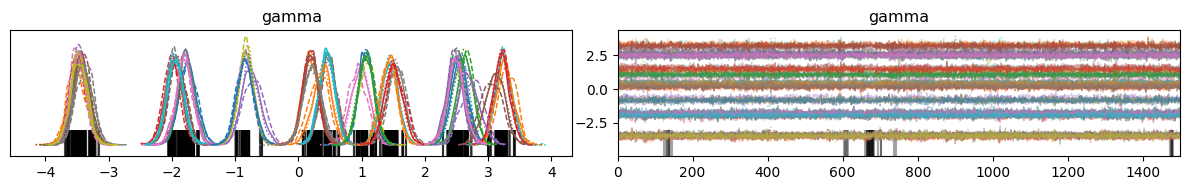

In [13]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["gamma"])
plt.tight_layout()

In [14]:
samples = fit.stan_variables()

y_tr_hat = samples["y_tr_hat"].mean(0)
y_te_hat = samples["y_te_hat"].mean(0)

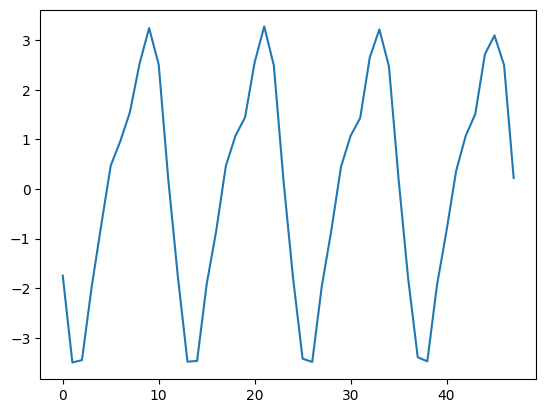

In [16]:
plt.plot(samples["gamma"].mean(0))

In [17]:
y_hat = np.hstack((y_tr_hat, y_te_hat))

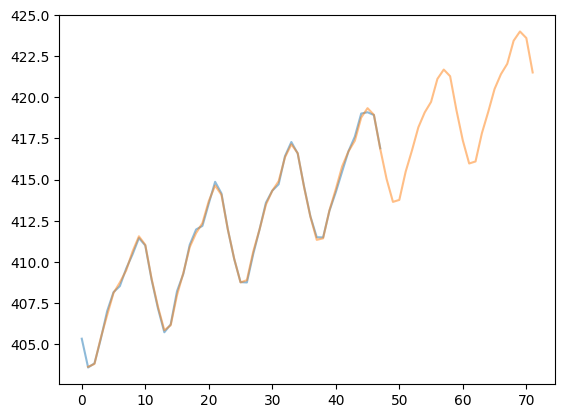

In [18]:
plt.plot(y_tr, alpha=0.5)
plt.plot(y_hat, alpha=0.5)
# plt.plot(y_te_hat)